Author: Abdulrahman Altahhan,  2024.

The notebook uses a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard Python libraries (numpy, matplotlib etc.).
Please note that you will need permission from the author to use the code for research, commercially or otherwise.

# Worksheet 2- Q Value Function: K-armed Bandit and Learning Q

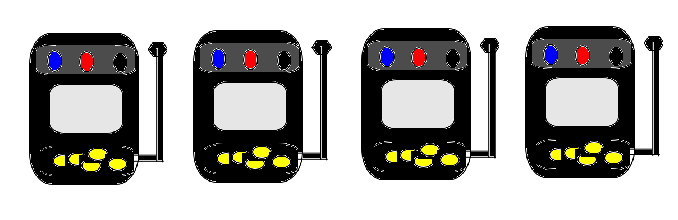

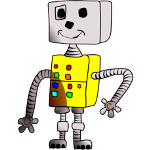

In this lesson you will learn about the k-armed bandit problem and its applications in RL. This problem is useful in understanding the basics of RL, in particular it demonstrates how an algorithm can *learn* an action-value function that we normally denote as Q in RL. 

**Learning outcomes**

1. understand the role the action-value function plays in RL and its relationship with a policy
2. appreciate the difference between stationary and non-stationary problems
3. understand how to devise a samples averaging solution to approximate an action-value function
4. appreciate the different policies types and the role a policy plays in RL algorithms

**Reading**:
The accompanying reading of this lesson are **chapters 1 and 2** of our text book available online [here](http://incompleteideas.net/book/RLbook2020.pdf). Please note that we explain the ideas of this topic from a practical perspective and not from a theoretical perspective which is already covered in the textbook.

In this lesson we develop the basic ideas of dealing with actions and policies which are the distinctive elements that set RL apart from other machine learning sub-disciplines. We study a simple but effective problem of the k-armed bandit. This problem is manifested in other scenarios such as when a medical specialist wants to decide which treatment to give for a patient from a set of medicine, some of which he/she are trying for the first time(exploring). 

Our toy problem is similar to a usual bandit but it is assumed that there is a set of k actions that the agent can choose from. We want to reach an effective policy that allows the agent to maximise its returns (wins). The bandit is assumed to have a Gaussian distribution around a mean reward that is different for each action (armed). Each time an armed is pulled (in our RL terminology we say an action is taken) the bandit will return a reward (positive or negative) by drawing from its Gaussian reward's distribution. The agent's task is to guess which action of these has the highest mean and pull it all the time to maximise its wins. Note that the distributions are fixed and not changing, although we can relax this assumption later.

Ok let us get started! 


Below we import libraries that will be necessary for our implementation. For RL sampling and random number generation is of at most importance we will use them quite extensively. You have come across these in earlier module and if in doubt you can consult the library help available online.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from numpy import arange
from numpy.random import rand,randn, seed, randint, choice, uniform, normal, multivariate_normal
import matplotlib.pyplot as plt
from tqdm import trange
import time

## Motivating Example
Let us assume that we have an armeded bandit with two livers.

### Scenario a
- We have a deterministic reward function that has a reward of -5 for action $a_1$ (pulling bandit 1)
- We have a deterministic reward function that has a reward of 00 for action $a_2$ (pulling bandit 2)
   
What is the optimal policy for this bandit?

### Scenario b
- We have a nondeterministic reward function that has a reward of either -5 or 15 with equal probabilities of .5 for action $a_1$ (pulling bandit 1)
- We have a nondeterministic reward function that has a reward of either 00 or 10 with equal probabilities of .5 for action $a_2$ (pulling bandit 2)
   
   

1. What is the net overall reward for actions $a_1$ and $a_2$?
1. What is the optimal policy for this bandit?
1. How many optimal policies we have for this bandit?

### Scenario c
- We have a nondeterministic reward function that has a reward of either -5 or 15 with probabilities .4 and .6 for action $a_1$ (pulling bandit 1)
- We have a nondeterministic reward function that has a reward of either 00 or 10 with probabilities .5 and .5 for action $a_2$ (pulling bandit 2)
   

1. What is the net overall reward for actions $a_1$ and $a_2$?
1. What is the optimal policy for this bandit?
1. How many optimal policies we have for this bandit?
1. Can find a way to represent this 


In the code below, we use rand() and arange() functions. rand() is a random number generator function. Each time it is run, it will give a different number in the range [0,1]. arange(), on the other hand, is useful to give us a set of uniformly distributed numbers.

In [3]:
rand()

0.12724275660014228

In [4]:
arange(0,1,.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [5]:
# obtaining the value of an action a with binary reward

def Q(pr=.5, r1=15, r2=-5):
    R = 0
    N = 100000
    for i in range(N):
        R += r1 if rand() <= pr else r2

    return R/N

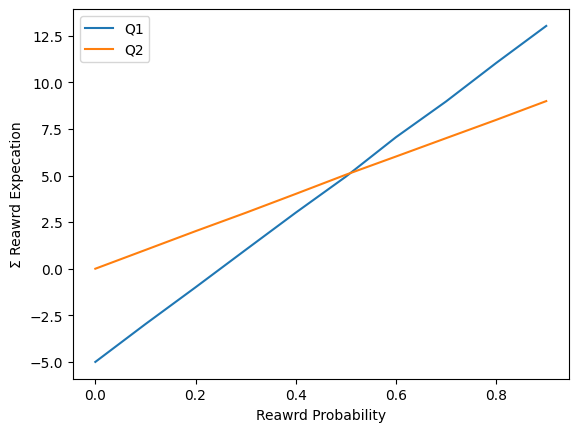

In [6]:
Pr = arange(0,1,.1)
Qs1 = [Q(pr, 15, -5) for pr in Pr]
Qs2 = [Q(pr, 10,  0) for pr in Pr]

plt.xlabel('Reawrd Probability')
plt.ylabel('Σ Reawrd Expecation')
plt.plot(Pr, Qs1, label='Q1')
plt.plot(Pr, Qs2, label='Q2')
plt.legend()
plt.show()

As can be seen, the two bandits functions intersect with each other at the .5 probability, meaning they are equivalent for this probability. For other probabilities Bandit 1 is superior for pr>.5 (and hence an optimal policy will be to select this bandit always), while Bandit 2 is superior for pr<.5 (and hence an optimal policy will be to select this bandit always). But bear in mind that we do not know the underlying probability before hand, and we would need to try out both to obtain an estimation for their corresponding value functions to be able to come up with a suitable policy.

Ok, now we move into covering the different concepts of the multi armeded bandit in more details.

We start by developing simple functions for 
1. returning an action from a stationary policy and 
2. returning a simple fixed reward from a stationary distribution

## Stationary probability

In [7]:
def stationary(p=[.5, .2, .3]):
    return choice(np.arange(0,len(p)), 1, p=p)[0]

stationary()

1

As we can see we passed a distribution for a set of 3 actions and the function chose from these 3 actions according to the distribution. Each time you run the above code it may give a different action. If you repeat the process you will find out that the action choices are distributed according to the passed distribution.

In [8]:
n = 10000
counts = np.array([0,0,0])
for _ in range(n):
    counts[stationary(p=[.5, .2, .3])]+=1

print((counts/n).round(2))
    


[0.49 0.21 0.3 ]


## Stationary and non-stationary reward
Once an action is sampled, we can return its reward from a set of rewards. 
We can start by assuming that each action has a fixed reward. Below we show how to obtain the reward.

In [9]:
def reward(a, r=[10, 20, 30]):
    return r[a]

print(reward(0), reward(1), reward(2))

10 20 30


Such a reward will be very easy to guess for an observer by just recording each action occurrence once. To address this, we can assume that each action's reward can vary around a mean and a Gaussian, we get lots of variations that makes it difficult for an observer to know the expected reward directly.


In [10]:
def reward(a, r=[-20, -30, 40]):
    return r[a]+r[a]*randn()

print(reward(0), reward(1), reward(2))

17.404930758042624 -57.19593932274351 4.167635592437634


On average we still expect to obtain more reward by choosing the third action(2) and if we play enough (by sampling from the rewards by taking a specific action) we will obtain the mean of the reward. Of course in a real game this would have an immense loss on the player that it is not a practical worry.

In [11]:
rewards = np.array([0,0,0])
n = 100000
for a in range(3):
    for _ in range(n):
        rewards[a] += reward(a)

(rewards/n).round(0)

array([-20., -29.,  39.])

Note that we still call the above distribution as stationary since it is not changing. So the first case was a point based believe and the second was a stationary distribution. Often, we deal with non-stationary distribution where the distribution itself changes while the agent is interacting with the environment. For example, if the mean of the reward itself is changing then this becomes a non-stationary distribution and the problem becomes non-stationary. Non-stationary problems are common in RL and we will deal with them often. They occur as an artifact of the learning process itself where the agent estimation of the action-value function changes with time which in turn changes the agent policy. This will become clearer in this and other lessons.

## Averaging the Rewards for greedy and ε-greedy policies

Greedy policy is a simple policy that always picks the action with the highest action-value.
On the other hand, an ε-greedy policy is similar to a greedy policy, however it allows the agent to pick random exploratory actions from time to time. The percentage of those exploratory actions is designated by ε (epsilon). Usually, we set ε to .1 (10%) or .05 (5%). A third type of a greedy policy is a dynamic ε-greedy policy which anneals or decays the exploration factor ε with time. In practice, ε-greedy policy usually works fine and better than more sophisticated policies that strike balance between exploration and exploitation (taking the greedy action is called exploitation while taking other actions is called exploration). Regardless of how, we need to allow for some form of exploratory actions otherwise it would not be possible for the agent to improve its policy.

Below we show an implementation bandit function that uses an ε-greedy policy. nA denotes the number of actions (number of armeds to be pulled). Because we are only dealing with actions the Q function has the form of Q(a). The armed bandit is non-associative problem, meaning we do not deal with states. Later we will deal with associative problems where Q(s,a) has two inputs the state and the action. 

Below we create a function that takes a bandit (in the form of a set of rewards each of which corresponds with an action) and generates a value Q that quantifies the value/benefit that we obtain by taking each action. This is a simple improvement over the code that we have just written earlier to obtain the expected reward of an action. This time we choose actions *randomly instead of uniformly* and hence we need to keep a count of each action. At the end we just divide the sum of obtained rewards over the action's count to obtain the average which is a good estimator of the expected reward.

In [12]:
rand() #[0,1)
Actions =    [0,  1,    2]
Q = np.array([0,  10,   10])
C = np.array([100,50,  75])
Q.argmax()
# print(Q/C)

choice(np.argwhere(Q==Q.max()).ravel())

2

In [13]:
def Q_bandit_fixed(bandit, ε=.1, T=1000):
    r  = bandit      # the bandit is assumed to be a set of rewards for each action
    nA = len(r)      # number of actions
    Q = np.zeros(nA) # action-values
    C = np.ones(nA)  # action-counts
    avgR = np.zeros(T+1)
    
    for t in range(T):
        # ε-greedy action selection (when ε=0 this turns into a greedy selection)
        if rand()<= ε: a = randint(nA)
        else:          a = (Q/C).argmax()
        
        Q[a] += r[a]
        C[a] += 1
        avgR[t+1] = (t*avgR[t] + r[a])/(t+1)

        
    plt.plot(avgR, label='average reward ε=%.2f'%ε)
    plt.legend()
    return Q/C

Let us see how the Q_bandit_fixed will learn to choose the best action that yields the maximum returns.

array([0.0983871 , 0.19444444, 0.69922652])

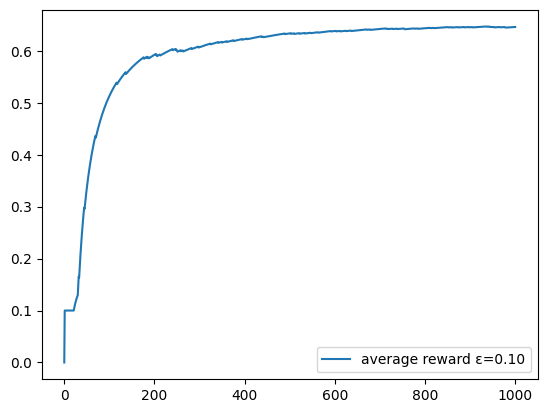

In [14]:
Q_bandit_fixed(bandit=[.1, .2, .7])

As we can see it has improved to more than 0.6.

Let us see how the completely greedy policy would do on average:

array([0.0999001, 0.       , 0.       ])

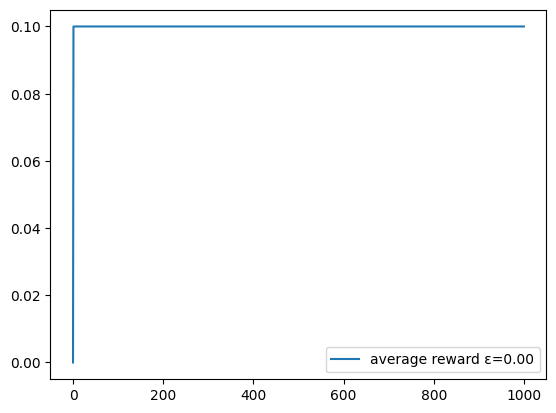

In [15]:
Q_bandit_fixed(bandit=[.1, .2, .7], ε=0)

As we can see it could not improve beyond 0.1

The main restriction in Q_bandit_fixed( ) function is that we assume that the reward function is fixed (hence the name Q_bandit_fixed). I.e., each action will receive a specific reward that does not change. This made the above solution a bit excessive since we could have just summed the rewards and then took their max. Nevertheless, this is useful as a scaffolding for our next step.

In the next section we develop a more general armed-bandit function that allows for the reward to vary according to some *unknown* distribution. The Q_banditAvg function will learn the distribution and find the best action that will allow it to obtain a maximal reward on average, similar to what we have done here.

## 10-armed Bandet Testbed: Estimating Q via Samples Average

Remember that Q represents the average/expected reward of an action from the start up until time step $t$ exclusive. Later we will develop this idea to encompass what we call the expected return of an action.
q* (qˣ in the code) represents the actual action-values for the armeds which are a set of reward that has been offset by a normal distribution randn(). This guarantees that on average the rewards of an action a is q*[a] but it will make it not easy for an observer to know exactly what the expected reward is.

### Generate the experience(sampling)
generate an experience (rewards)

In [16]:
def bandit(a, qˣ):
    return qˣ[a] + randn()

print(bandit(a=1, qˣ=normal(0, 1, 10)))

-1.5316084000865826


This kind of function get us a multivariate normal distribution of size k. To see how we will generate a sample bandit with all of its possible data and plot it.

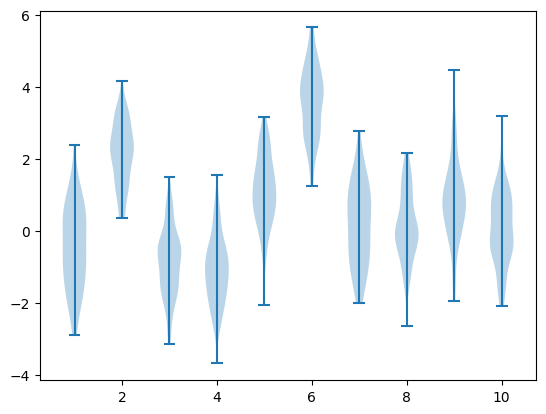

In [17]:
def generate_a_bandit_data(qˣ, T):
    nA = qˣ.shape[0]
    r = multivariate_normal(qˣ, np.eye(nA), T)
    plt.violinplot(r)
    plt.show()

generate_a_bandit_data(normal(0, 1, 10), T=100)

### Learning the bandit Q action-values

Now we turn our attention to learning the Q function for an unknown reward distribution. Each action has its own Gaussian distribution around a mean but we could use other distributions. The set of means are themselves drawn from a normal distribution of mean 0 and variance of 1.

In [18]:
# learn the Q value for bandit and use it to select the action that will win the most reward
def Q_banditAvg(qˣ, ε=.1, T=1000):    
    
    # |A| and max(q*)
    nA   = qˣ.shape[0]            # number of actions, usually 10
    amax = qˣ.argmax()            # the optimal action for this bandit

    # stats.
    r  = np.zeros(T)                  # reward at time step t
    a  = np.zeros(T, dtype=int)       # chosen action at time step t, needs to be int as it will be used as index
    oA = np.zeros(T)                  # whether an optimal action is selected at time step t
    
    # estimates
    Q = np.zeros(nA)                  # action-values all initialised to 0
    N = np.ones(nA)                   # actions selection count

    
    for t in range(T):
        # action selection is what prevents us from vectorising the solution which must reside in a for loop
        if rand()<= ε: a[t] = randint(nA)       # explore
        else:          a[t] = (Q/N).argmax()    # exploit
        
        # update the stats.
        r[t]  = bandit(a[t], qˣ)
        oA[t] =        a[t]==amax
        
        # update Q (action-values estimate)
        N[a[t]] += 1
        Q[a[t]] += r[t] 

    return r, oA

Let us now run this function and plot one 10-armed bandits

Text(0, 0.5, '%Optimal action')

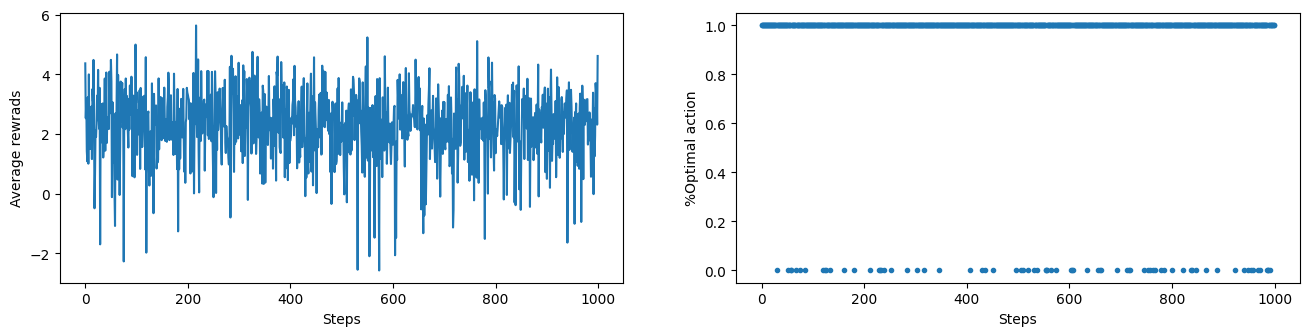

In [19]:
R, oA = Q_banditAvg(normal(0, 1, 10) , ε=.1, T=1000)

plt.gcf().set_size_inches(16, 3.5)
plt.subplot(121).plot(R); plt.xlabel('Steps'); plt.ylabel('Average rewrads')
plt.subplot(122).plot(oA,'.'); plt.xlabel('Steps'); plt.ylabel('%Optimal action')


Note how the % of optimal actions for one trial (run) takes either 1 or 0. This figure to the left seems not be conveying useful information. However when we average this percentage over several runs we will see a clear learning pattern. This is quite common theme in RL. We often would want to average a set of runs/experiments due to the stochasticity of the process that we deal with.

### Multiple runs (aka trials)
We need to average multiple runs to obtain a reliable unbiased results that reflect the expected performance of the learning algorithm.

In the Q_bandits_runs() we pass on any extra keyword arguments to the Q_bandit() function. This trick will save us to redefine arguments and it will be utilised extensively in our treatment of RL algorithms. 


If you are not familiar with it please refer to the many online tutorials such as [this](https://realpython.com/python-kwargs-and-args/). Before you do that we provide a quick cap here. You can think of and read ' **kw ' to be equivalent to ' etc ' in plain English.

In [20]:
def func1(c=10): print(c); func2() 
def func2(d=20): print(d)
func1(c=10)

10
20


The problem with the above is that we cannot change d via func1, to do so we can use the arbitrary **kw trick. Note that kw is just a dictionary of keys and values like any python dictionary.

In [21]:
def func1(c=10, **kw): print(c); func2(**kw)
def func2(d=20):       print(d)
func1(c=10, d=30)

10
30


As you can see we passed d inside func1 although it is not originally in the set of keywords arguments of func1. Also if we later changed the prototype of func2() we do not need to change func1(). For example:

In [22]:
def func2(d=20, f=200): print(d); print(f)
func1(c=10, d=30, f=66)

10
30
66


One more thing: we use trange(runs) instead of range(runs) because it gives us a bar to indicate how much left for the process to finish. This is quite useful when we do extensive runs.

In [23]:
for run in trange(10):
    time.sleep(.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.63it/s]


Ok now we are ready to the Q_bandits_runs() definition.

In [24]:
def Q_bandits_runs(Q_bandit, runs=2000, T=1000,  k=10,  label='', **kw):
    #np.random.seed(20) # this allows us to generate the same experience for consistency, you can comment it out
    
    R = np.zeros((runs, T))  # rewards over runs and time steps
    oA = np.zeros((runs, T))  # optimal actions over runs and steps

    for run in trange(runs):
        
        # generate the k-armed bandit actual q* values by calling normal(0, 1, k) 
        R[run], oA[run] = Q_bandit(qˣ=normal(0, 1, k) , T=T, **kw)
        
    plt.gcf().set_size_inches(16, 3.5)
    
    subplotQ_bandits_runs(R.mean(0), 1, label=label, ylabel='Average rewrads')
    plt.yticks([0, .5, 1, 1.5])
    
    subplotQ_bandits_runs(oA.mean(0), 2, label=label, ylabel='%Optimal action')
    plt.yticks(np.arange(0,1.2,.2), ['0%', '20%', '40%', '60%', '80%', '100%'])


Where subplotQ_bandits_runs function handles the learning curve plots for us and is given below. Note that in the above we obtain different set of 10-bandit distributions and conduct an experimental run on them. Because all of them are normally standard distribution their sums of rewards (values) converges to the same quantity around 1.5.

In [25]:
def subplotQ_bandits_runs(experience, i, label, ylabel=''):
    x = int(.6*experience.shape[0])
    plt.subplot(1,2,i)
    
    plt.plot(experience)
    plt.annotate(label, xy=(x,experience[x]), fontsize=14)
    plt.xlabel('Steps')
    plt.ylabel(ylabel)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

### Action Selection (Policy) Comparison:
Now we are ready to compare between policies with different exploration rates ε. Note that ε kw(keyword argument) has been passed on to the Q_bandit() function from the Q_bandits_runs() function.

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 176.97it/s]


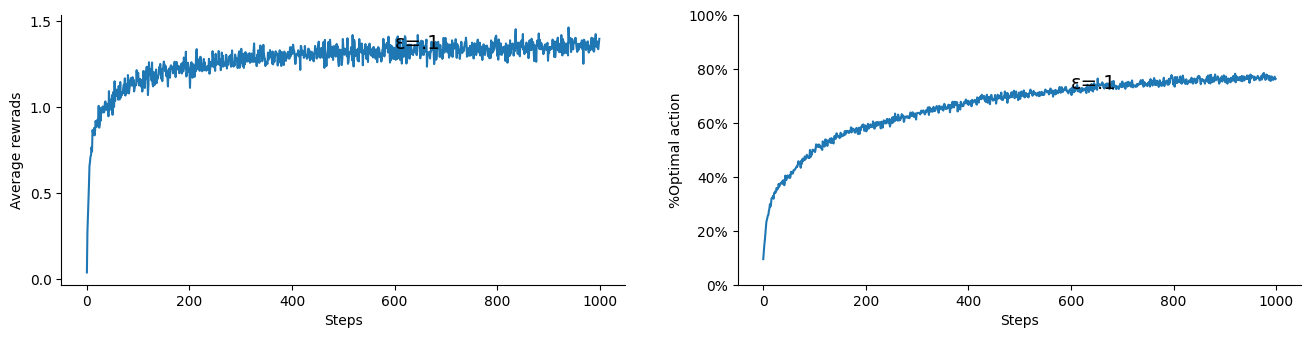

In [26]:
Q_bandits_runs(ε=.1,  label='ε=.1',  Q_bandit=Q_banditAvg, runs=1000)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 212.03it/s]


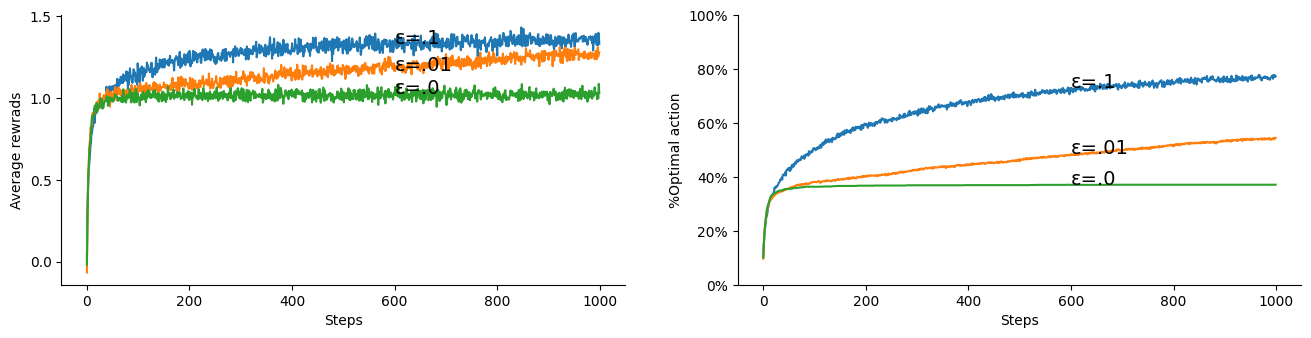

In [27]:
Q_bandits_runs(ε=.1,  label='ε=.1',  Q_bandit=Q_banditAvg)
Q_bandits_runs(ε=.01, label='ε=.01', Q_bandit=Q_banditAvg)
Q_bandits_runs(ε=.0,  label='ε=.0' , Q_bandit=Q_banditAvg)

As we can see the ε=.1 exploration rate seems to give us a sweet spot. Try ε=.2 and see the effect.
This empirically indicates that indeed we need to allow the agent to explore in order to come up with a viable optimal or close to optimal policy.

## Incremental Implementation

If we look at the sum

$$
\begin{aligned}
Q_{t+1}  = \frac{1}{t}\sum_{i=1}^{t}R_i &= \frac{1}{t}\left(\sum_{i=1}^{t-1}R_i + R_t\right)\\
        &= \frac{1}{t}\left((t-1)\frac{\sum_{i=1}^{t-1}R_i}{t-1} + R_t\right)\\ 
        &= \frac{1}{t}\left(\left(t-1\right)Q_t + R_t\right)\\ 
Q_{t+1} &= Q_t + \frac{1}{t}\left(R_t - Q_t\right)\\ 
\end{aligned}
$$
We can see that we can write the estimate in an incremental form that allows us to update our estimate $Q_t$ instead of recalculate the sum in each time step. This is very handy when it comes to efficiently implement an algorithm to give us the sum. Further, it  turns out that it also has other advantages. To realise this, note that the $\frac{1}{t}$ diminishes when $t$ grows, which is natural for averages. But if we want the latest rewards to have a bigger impact (weights) then we can simply replace this fraction by a constance$\alpha$ to obtain the following **incremental update**

$$
\begin{aligned} 
    Q_{t+1} = Q_t + \alpha\left(R_t - Q_t\right)
\end{aligned}
$$

Note that incremental updates plays a very important role in RL and we will be constantly seeking them due to their efficiency in online application.

Below we redefine our Q_bandit function to be incremental. Note how we adjust each Q[a] with the difference between its reward estimate and the actual reward estimate then we divide by the action count N[a]

$$Q[a] += (R[a,t]- Q[a])/N[a] $$ 


We also tidy up a bit so that the setup code is not repeated later when we change the update.

In [28]:
def bandit_init(qˣ, T, q0=0):

    # |A| and max(q*)
    nA   = qˣ.shape[0]                # number of actions, usually 10
    amax = qˣ.argmax()                # the optimal action for this bandit

    # stats.
    r  = np.zeros(T)                  # reward at time step t
    a  = np.zeros(T, dtype=int)       # chosen action at time step t, needs to be int as it will be used as index
    
    # estimates
    Q = np.ones(nA)*q0                # action-values all initialised to q0
    N = np.zeros(nA)                  # 👀 earlier we cheated a bit by initialising N to ones to avoid div by 0

    return nA,amax,  r,a,  Q,N


In [29]:
def Q_banditN(qˣ, ε=.1, T=1000, q0=0):
    nA,amax,  r,a,  Q,N = bandit_init(qˣ, T, q0)
    
    for t in range(T):
        # choose a[t]
        if rand()<= ε: a[t] = randint(nA)     # explore
        else:          a[t] = Q.argmax()      # exploit, 👀 note that we do not use Q/N as before
        
        # get the reward from bandit
        r[t]  = bandit(a[t], qˣ)
        
        # update Q (action-values estimate)
        N[a[t]] += 1
        Q[a[t]] += (r[t] - Q[a[t]])/N[a[t]]   

    return r, a==amax

Now we can call again our Q_bandits_runs which will use the newly defined Q_bandit

100%|███████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 242.84it/s]


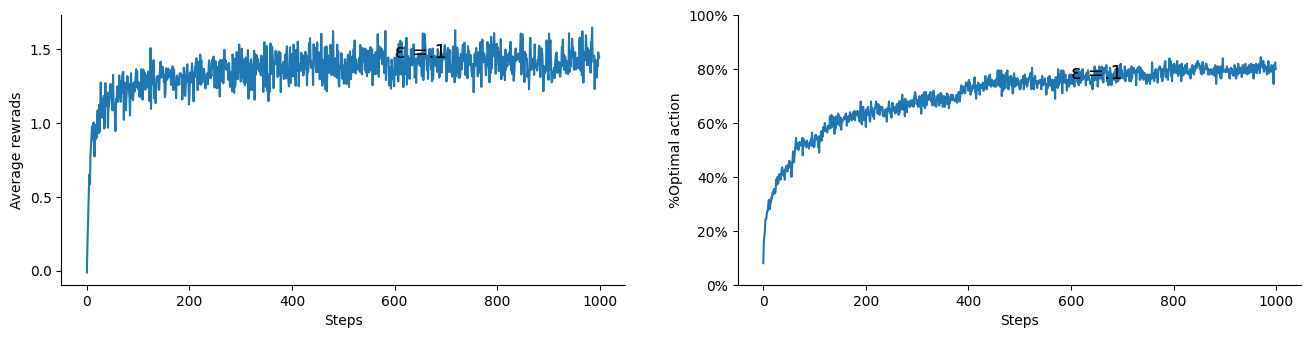

In [30]:
Q_bandits_runs(ε=.1,  label='ε =.1',  Q_bandit=Q_banditN, runs=200)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.49it/s]


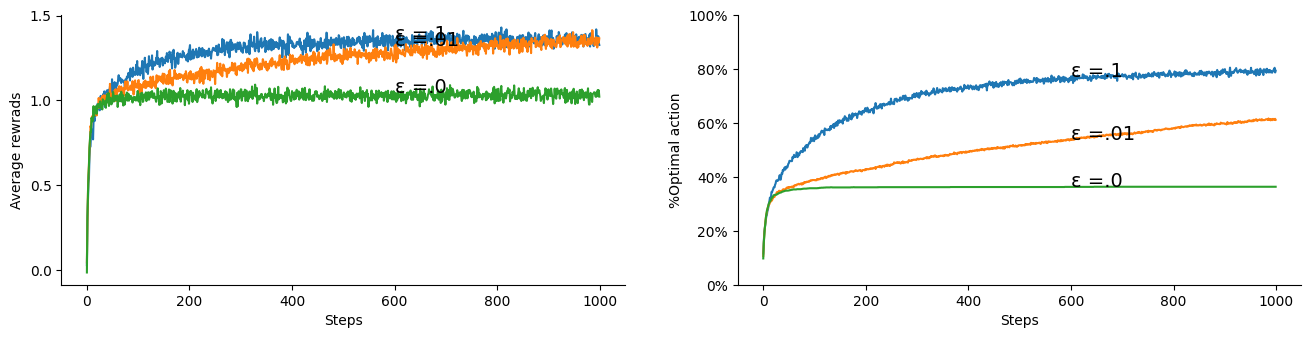

In [31]:
#Q_bandits_runs(ε=.2)
Q_bandits_runs(ε=.1,  label='ε =.1',  Q_bandit=Q_banditN)
Q_bandits_runs(ε=.01, label='ε =.01', Q_bandit=Q_banditN)
Q_bandits_runs(ε=.0,  label='ε =.0',  Q_bandit=Q_banditN)

## Non-stationary Problems
The limitation of the above implementation is that it requires actions counts and when the underlying reward distribution changes (non-stationary reward distribution) it does not respond well to take these changes into account. A better approach when we are faced with such problems is to use a fixed size step <1 instead of dividing by the actions count. This way, because the step size is small the estimate gets updated when the underlying reward distribution changes. Of course this means that the estimates will keep changing even when the underlying distribution is not changing, however in practice this is not a problem when the step size is small enough. This effectively gives more weights to recent updates which gives a good changes-responsiveness property for this and similar methods that use a fixed size learning step $\alpha$.

Note that the majority of RL problem are actually non-stationary. This is because, as we shall see later, when we gradually move towards an optimal policy by changing the Q action-values, the underlying reward distribution changes in response to taking actions that are optimal according to the current estimation. This is also the case here but in a subtle way.

In [32]:
Q = np.array([0, 0, -1])

choice(np.argwhere(Q==Q.max()).ravel())

# print(Q.argmax())

# if rand()<.1: print(randint(3))
# else: print(Q.argmax())


0

In [33]:
def Q_banditα(qˣ,  α=.1, ε=.1, T=1000, q0=0):
    
    nA, amax, r, a, Q, _ = bandit_init(qˣ, T, q0)
    
    for t in range(T):
        # choose a[t]
        if rand()<= ε: a[t] = randint(nA)     # explore
        else:          a[t] = Q.argmax()      # exploit, 👀 note that we do not use Q/N as before
        
        # get the reward from bandit
        r[t]  = bandit(a[t], qˣ)
        
        # update Q (action-values estimate)
        Q[a[t]] += α*(r[t] - Q[a[t]])  # 👀 constant step-size α: yields exponential recency-weighted average
                                       #    similar form of update will be used Throughout the unit

    return r, a==amax

The above is a neat way to learn the action-value function and it preferred due the reasons that we mentioned earlier.

### Comparison
Let us now compare different exploration rates for this learning function. 

100%|████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 71.96it/s]


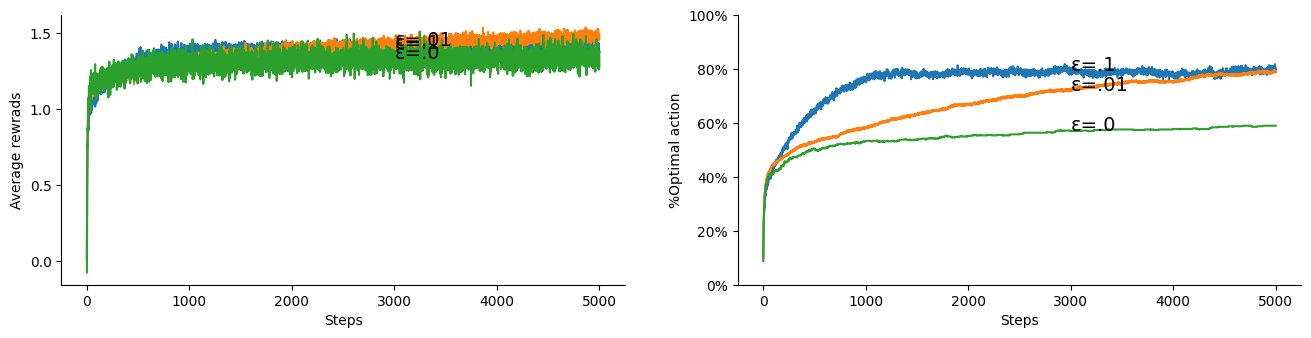

In [34]:
Q_bandits_runs(ε=.1,  label='ε=.1',  Q_bandit=Q_banditα, T=5000, runs=2000)
Q_bandits_runs(ε=.01, label='ε=.01', Q_bandit=Q_banditα, T=5000, runs=2000)
Q_bandits_runs(ε=.0,  label='ε=.0',  Q_bandit=Q_banditα, T=5000, runs=500)

## Q_bandit in a better form

Let us finally define some useful policy functions and redefine and further simplify the Q_bandit function.

### Policies: Exploration vs. Exploitation
Getting the right balance between exploration and exploitation is a constant dilemma in RL.
One simple strategy as we saw earlier is to explore constantly occasionally ε% of the time! which we called ε-greedy. Another strategy is to insure that when we have multiple actions that are greedy we chose ebtween them equally and not bias one over the other. This is what we do in the greedyStoch policy below.

We start by showing how to randomly choose between two max Q value actions.

In [35]:
Q = np.array([.2 , .4, .4])
actions=[]
for _ in range(30):
    actions.append(choice(np.argwhere(Q==Q.max()).ravel()))
print(actions)

[1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2]


In [36]:
# returns one of the max Q actions; there is an element of stochasticity in this policy
def greedyStoch(Q):   
    return choice(np.argwhere(Q==Q.max()).ravel())


# returns the first max Q action most of the time (1-ε)
def εgreedy(Q, ε):
    return Q.argmax() if rand() > ε else randint(Q.shape[0])
    

def εgreedyStoch(Q, ε):
    return greedyStoch(Q) if rand() > ε else randint(Q.shape[0])

In [37]:
def Q_banditα(qˣ,  α=.1, ε=.1, T=1000, q0=0, policy=εgreedy):
    nA, amax, r, a, Q, _ = bandit_init(qˣ, T, q0)
    
    for t in range(T):
        # using a specific policy
        a[t] = policy(Q, ε)               
        
        # get the reward from bandit
        r[t]  = bandit(a[t], qˣ)
        
        # update Q (action-values estimate)
        Q[a[t]] += α*(r[t] - Q[a[t]])  
        
        
    return r, a==amax

Let us compare different *learning rates* α to see how our Q_bandits() function reacts to them. 

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 296.34it/s]


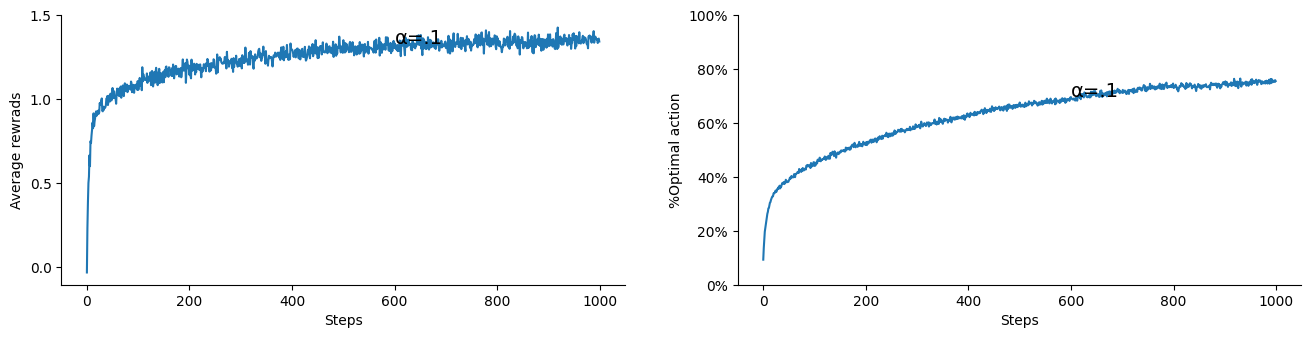

In [38]:
Q_bandits_runs(α=.1,  label='α=.1',  Q_bandit=Q_banditα)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 302.41it/s]


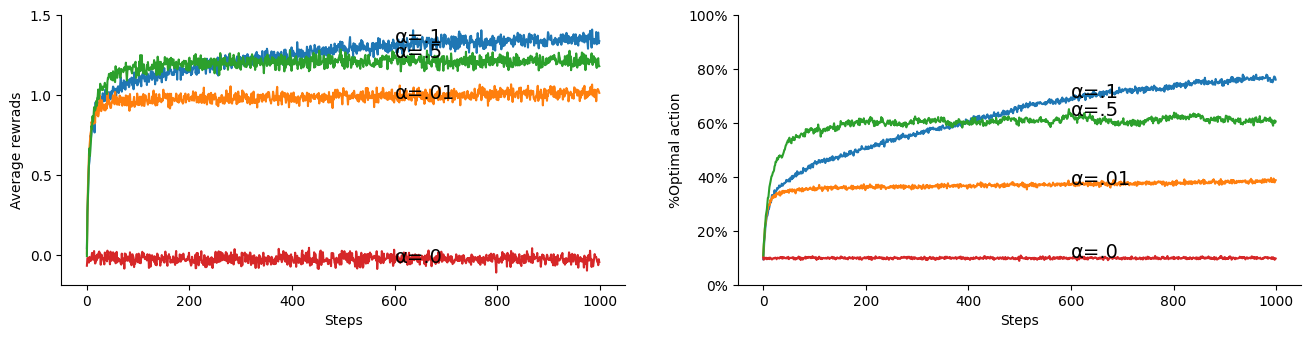

In [39]:
Q_bandits_runs(α=.1,  label='α=.1',  Q_bandit=Q_banditα)
Q_bandits_runs(α=.01, label='α=.01', Q_bandit=Q_banditα)
Q_bandits_runs(α=.5,  label='α=.5',  Q_bandit=Q_banditα)
Q_bandits_runs(α=.0,  label='α=.0',  Q_bandit=Q_banditα)

## Optimistic Initial Values

It turns out that we can infuse exploration in the RL solution by optimistically initialising the Q values.
This encourages the agent to explore due to its disappointment when its initial Q values are not matching the reward values that are coming from the ground (interacting with the environment). This intrinsic exploration motive to explore more actions at the start, vanishes with time when the Q values become more realistic. 

This is a good and effective strategy for exploration. But of course it has its limitations, for example it does not necessarily work for if there a constant or renewed need for exploration. This could happen either when the task or the environment are changing. Below, we show the effect of optimistically initiating the Q values on the 10-armed bandit testbed. We can clearly see that without exploration i.e. when ε=0 and Q=5 initial values outperformed the exploratory policy ε=.1 with Q=0 initial values.

Ok, we will apply the same principle to stochastically return one of the max Q actions which is coded in greedyStoch() policy. This type of policy will prove useful later when we deal with control.

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 349.84it/s]


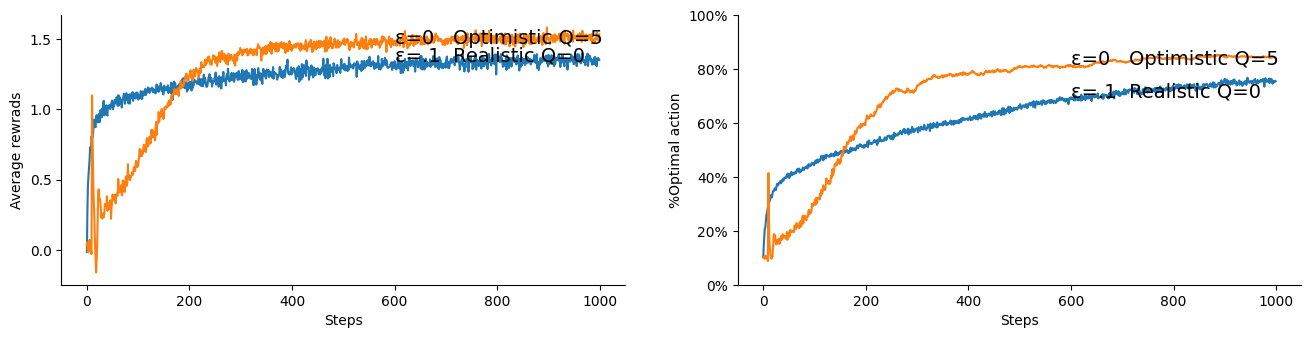

In [40]:
Q_bandits_runs(ε=.1, q0=0, label='ε=.1  Realistic Q=0',  Q_bandit=Q_banditα)
Q_bandits_runs(ε=0 , q0=5, label='ε=0   Optimistic Q=5', Q_bandit=Q_banditα)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:17<00:00, 25.87it/s]


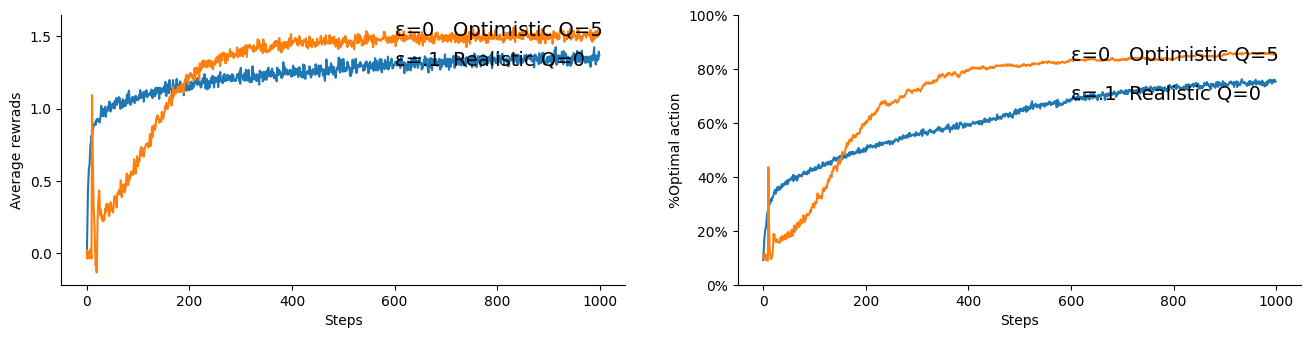

In [41]:
Q_bandits_runs(ε=.1, q0=0, label='ε=.1  Realistic Q=0',  Q_bandit=Q_banditα, policy=εgreedyStoch)
Q_bandits_runs(ε=0 , q0=5, label='ε=0   Optimistic Q=5', Q_bandit=Q_banditα, policy=εgreedyStoch)

As we can see above the optimistic initialization has actually beaten the constant exploration rate and it constitutes a very useful trick for us to encourage the agent to explore while still acting greedily. Of course we can combine both strategies and we will leave this for you as a task. We will use this trick in our coverage of RL in later lessons.

## Conclusion
In this lesson you have learned about the importance of the action value function Q and stationary and non-stationary reward distribution and how we can devise a general algorithms to address them and we concluded by showing an incremental learning algorithm to tackle the k-armed bandit problem. You have seen different exploration strategy and we extensively compared between exploration rates and learning rates for our different algorithms.

## Your Turn

1. Define a softmax policy as per its definition in eq. 2.11, then compare the Q_bandits_runs on ε-greedy and softmax policies.
2. Combine the optimistic initialisation and exploration rates and see how the bandit_Q function react to them.

[Back to TOC](IntroductionTOC.ipynb)